该notebook文档主要介绍了Transformer模型的基础架构组成的完整实现，文档内容参考自`https://github.com/harvardnlp/annotated-transformer`.



In [ ]:
!pip install transformers datasets

<h3>目录</h3>
<ul>
  <li><a href="#transformer基础架构实践">Transformer基础架构实践</a>
    <ul>
      <li><a href="#模型架构">模型架构</a>
        <ul>
          <li><a href="#基础组件">基础组件</a></li>
          <li><a href="#编码器架构">编码器架构</a></li>
          <li><a href="#解码器架构">解码器架构</a></li>
          <li><a href="#自注意力机制实现">自注意力机制实现</a></li>
          <li><a href="#位置编码">位置编码</a></li>
        </ul>
      </li>
      <li><a href="#模型训练">模型训练</a>
        <ul>
          <li><a href="#学习率定义">学习率定义</a></li>
          <li><a href="#数据集读取和解析">数据集读取和解析</a></li>
          <li><a href="#计算空间优化">计算空间优化</a></li>
        </ul>
      </li>
      <li><a href="#实例">实例</a>
        <ul>
          <li><a href="#语言翻译">语言翻译</a></li>
        </ul>
      </li>
    </ul>
  </li>
</ul>

In [3]:
# Standard PyTorch imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy
from torch.autograd import Variable

# For plots
%matplotlib inline
import matplotlib.pyplot as plt


### 模型架构 Model Architecture

### 模型基本组件   

In [5]:
# 层正则化实现，数据减均值，除以方差，同时设置缩放系数和偏置（初始值分别为1和0），参数量和特征数据的维度相同
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [6]:
# 实现层归一化和残差功能的公共组件模块，一个block里有两个该组件，可以实现代码的复用
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity we apply the norm first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    # 从下一个cell中可以看到，此处的sublayer为传入的lambda函数，实现了自注意力机制的计算
    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer function that maintains the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [7]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

### 编码器架构

In [8]:
# 一个Transformer Layer（Block）组件的定义，和参考图进行对比，每一个Block有两个sublayer，其中:
# sublayer[0]为自注意力模块的部分
# sublayer[1]为前馈网络模块feed_forward的部分
class EncoderLayer(nn.Module):
    "Encoder is made up of two sublayers, self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [9]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

We employ a residual connection [(cite)](he2016deep) around each of the two sub-layers, followed by layer normalization [(cite)](layernorm2016).  

That is, the output of each sub-layer is $\mathrm{LayerNorm}(x + \mathrm{Sublayer}(x))$, where $\mathrm{Sublayer}(x)$ is the function implemented by the sub-layer itself.  We apply dropout [(cite)](srivastava2014dropout) to the output of each sub-layer, before it is added to the sub-layer input and normalized.  

To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{\text{model}}=512$.  

Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network.
在编码层的内部有两个部分：第一个部分为多头自注意力层，第二个部分为一般的前馈神经网络层（以全连接层进行实现）

### 解码器Blocks结构

In [10]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack.  Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization.  
以下代码的说明(待更新和补充)
- memory表示从编码器的结果的输出，将会作为K，V的输入，和解码器的query进行交叉注意力机制的计算
- 每一层有两个attention block
    - 第一个为解码层内部的attention，一般会采用因果的自注意力机制实现时序前向的注意力计算，具体通过mask相结合进行实现
    - 第二个为和编码层的attention的输出进行交叉自注意力机制的实现，这里的mask为src的mask，因为src有部分采用了padding，只需计算有信息部分的自注意力的相关矩阵的部分
    - 其中编码器每个block输出的hidden state（embedding）同时作为k和v和对应解码器的block的第一个因果自注意力机制进行计算


In [11]:
class DecoderLayer(nn.Module):
    "Decoder is made up of three sublayers, self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions.  This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position $i$ can depend only on the known outputs at positions less than $i$.

亦即因果(causual self attention block)自注意力机制的实现
创建一个注意力掩码（Attention Mask）。这个特殊的掩码通常被称为**“后续掩码” (Subsequent Mask)** 或 “前瞻掩码” (Look-ahead Mask)
在自然语言生成任务中，比如机器翻译，模型在生成第 i 个词时，只能依赖于它已经生成的前 i-1 个词，而不能“偷看”未来的词（即第 i 个、第 i+1 个词等）。
在计算自注意力（Self-Attention）时，它会**遮挡（mask out）**掉所有未来的位置，确保每个位置的输出只依赖于当前和之前的位置。
np.ones(attn_shape): 创建一个形状为 (1, size, size)、所有元素都为 1 的 NumPy 数组。
np.triu (triangle upper) 的作用是保留一个矩阵的上三角部分，将其余部分置为 0。参数 k 控制着对角线的位置：
- k=0 (默认): 保留主对角线及以上部分。
- k=1: 保留主对角线上方的部分，主对角线本身也被置为 0。
- k=-1: 保留主对角线下方部分。

torch.from_numpy(subsequent_mask) == 0有类似取反的作用
- 原来是 0 的位置，比较后变为 True。
- 原来是 1 的位置，比较后变为 False。

经过上述的处理后将形成了下三角为1的矩阵（包含对角线）

In [12]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

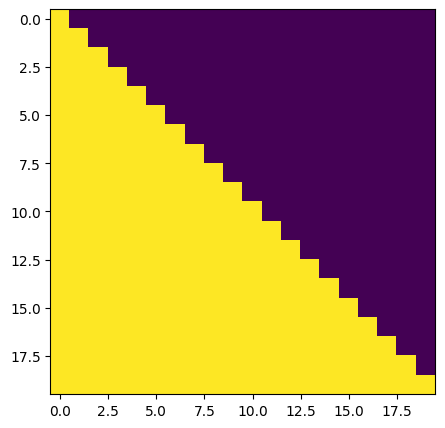

In [13]:
# The attention mask shows the position each tgt word (row) is allowed to look at (column).
# Words are blocked for attending to future words during training.
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

### 

Attention的计算流程图如下：      

<img width="220px" src="./images/atten_calculation.jpg">
                                                                 
$$                                                                         
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V               
$$       

具体的一些计算细节和技巧说明如下：自注意力机制的代码实现，这里用到了mask，mask为0的地方将不参与计算（经过softmax计算后其概率比重为0）

torch.matmul 的内部实现比这更高效，它使用的是一种叫做**批处理矩阵乘法（Batch Matrix Multiplication）**的机制

当 torch.matmul(tensor1, tensor2) 的输入张量维度大于 2 时，它遵循以下规则：
最后两维是矩阵：torch.matmul 将每个张量的最后两个维度视为要进行乘法运算的矩阵。
前面所有维度是“批次”维度：除最后两维之外的所有维度都被视为“批次”维度。torch.matmul 会在这些批次维度上进行广播（broadcasting）。
独立计算：它会把运算看作是一批独立的矩阵乘法。对于批次维度中的每一个组合，它都会执行一次标准的 2D 矩阵乘法。
关键在于：这个“批处理”操作不是通过 Python 循环实现的，而是在底层（如 C++ 或 CUDA）通过高度优化的代码执行的，能够充分利用硬件的并行计算能力。

以[batch, multi-head-count, tokens_capacity, d_k] 形状为例来分析。为了方便，我们用符号表示：[B, H, T, Dk]。  
B: batch_size (批次大小)  
H: multi-head-count (头的数量)  
T: tokens_capacity (序列长度)  
Dk: d_k (每个头的维度)  
计算 scores  scores = torch.matmul(query, key.transpose(-2, -1))    
query 的形状: (B, H, T, Dk)  
key 的形状: (B, H, T, Dk)  
key.transpose(-2, -1) 的形状，transpose(-2, -1) 会交换最后两个维度，所以，形状变为 (B, H, Dk, T)
现在，我们来看 torch.matmul 的输入：  
tensor1 (query): (B, H, T, Dk)  
tensor2 (key.transpose(...)): (B, H, Dk, T)    
因此，scores 的最终形状是 (B, H, T, T)，即(batch_size, num_heads, seq_len, seq_len) ，这正是我们期望的注意力分数矩阵的形状（对于每个头和每个批次项）
scores = scores.masked_fill(mask == False, -1e9)  
将掩码中为 False 的位置（即我们想遮挡的位置，如因果mask或者padding mask等）对应的注意力分数替换成一个非常大的负数（如 -1e9）。当这个带有极大负数的张量经过 Softmax 函数时，这些位置的概率会趋近于 0，从而有效地“忽略”了它们。

In [14]:
def attention(query, key, value, mask=None, dropout=0.0):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    # (Dropout described below)
    p_attn = F.dropout(p_attn, p=dropout)
    return torch.matmul(p_attn, value), p_attn

在 $(d_k)$ 较大时，点积结果的幅值会变得非常大，导致 Softmax 函数进入其梯度极小的饱和区域，从而阻碍有效学习。

> 为说明点积为何会变大，假设向量 $(q)$ 和 $(k)$ 的各分量均为独立同分布的随机变量，均值为 0、方差为 1。那么它们的点积  
> $[
> q \cdot k = \sum_{i=1}^{d_k} q_i k_i
> ]$  
> 的均值为 0，方差为 $(d_k)$。因此，随着 $(d_k)$ 增大，点积的波动幅度也随之增大。

为缓解这一问题，我们在点积结果上引入缩放因子 $(\frac{1}{\sqrt{d_k}})$，从而稳定 Softmax 的输入范围，确保梯度的有效性。 

### Multi-Head  Attention                                                                                                                                                                                                                                                                                                               
<img width="270px" src="./images/multihead-atten.jpg">
                                                                                                                                                                                                                                                                                                          
Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.                                                                                                                                                       
   
$$    
\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O    \\                                           
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)                                
$$                                                                                                                                                                                                                                                                                                                                                                                                                                                       
Where the projections are parameter matrices $W^Q_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$.                                                                                                                                                                                                                                                        

In this work we employ $h=8$ parallel attention layers, or heads. For each of these we use $d_k=d_v=d_{\text{model}}/h=64$. Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimensionality.   


多头自注意力机制的实现，h为head的数目，d_model为模型的输出的维度(batch_size, token_capacity, d_model)

```
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                    for l, x in zip(self.linears, (query, key, value))]
```

zip 函数在打包多个可迭代对象（如列表、元组）时，会以其中最短的那个为准。 一旦最短的可迭代对象耗尽，zip 就会停止。
self.linears: 这是一个 nn.ModuleList，通过 clones(..., 4) 创建，其长度为 4  
[Linear_Layer_0, Linear_Layer_1, Linear_Layer_2, Linear_Layer_3]  
(query, key, value): 这是一个元组，包含了三个张量，其长度为 3  
因此，zip(self.linears, (query, key, value)) 只会产生三对元素：
- (self.linears[0], query)
- (self.linears[1], key)
- (self.linears[2], value)
self.linears 中的第四个线性层 (self.linears[3]) 在这个列表推导中不会被使用。而在后续融合的使用

```
self.linears[-1](x)
```

关于attention的高阶张量的计算说明在上面已有提及。
下面这句代码将多个head的结果合并到到一起，形成[B,T,d_model]的张量输出   
最后再通过线性层进行一次融合后形成最终的张量输出[B,T,d_model]  

```
x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)\
```

In [15]:
#h为head数目，d_model为总的embedding的维度数，d_k为每一个head对应的embedding的维度数
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.p = dropout
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None

    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        # -1维度表示token的长度，如下先将embedding的维度拆解，然后将h和token的维度进行置换后实现统一的attention计算
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linears, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.p)

        # 3) "Concat" using a view and apply a final linear.
        # 置换回维度后再通过view转化为(B, T, D)的张量形状
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

### 注意力机制在我们模型中的应用

Transformer 在三个不同场景中使用了多头注意力机制：

1) **编码器-解码器注意力层**（Encoder-Decoder Attention）：  
   查询（queries）来自解码器的前一层，而键（keys）和值（values）则来自编码器的最终输出(不是“每个 Decoder stack 对应其同层的 Encoder stack”，而是 所有 Decoder 层都使用同一个 K/V 来源——即完整的 Encoder 输出的最后一层)。  
   这使得解码器中的每个位置都能关注输入序列中的所有位置，从而获取生成当前输出所需的相关上下文信息。  
   这一机制与序列到序列（sequence-to-sequence）模型中常见的编码器-解码器注意力结构一致。

2) **编码器中的自注意力层**（Self-Attention in the Encoder）：  
   在自注意力层中，查询、键和值均来自同一来源——在此即编码器前一层的输出。  
   因此，编码器中每一位置都能关注其前一层中的所有位置，从而充分融合整个输入序列的上下文信息。

3) **解码器中的自注意力层**（Self-Attention in the Decoder）：  
   类似地，解码器中的自注意力机制允许每个位置关注解码器中**截至该位置为止的所有先前位置**（包括自身）。  
   为保持模型的自回归特性（auto-regressive property），必须阻止解码器中向左的信息流动（即未来位置不能影响当前或过去位置的计算）。  
   我们通过在缩放点积注意力内部对 Softmax 输入进行**掩码处理**来实现这一点：将所有非法连接（即指向未来位置的连接）对应的值设为 \(-\infty\)，使其经 Softmax 后权重为零，从而有效屏蔽未来信息。                                                              

## Position-wise Feed-Forward  Networks                                                                                                                                                                                                                            
In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically.  This consists of two linear transformations with a ReLU activation in between.

$ \mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 +  b_2 $                                                                                                                                                                                                                                                                                                                                                                                        
While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1.  The dimensionality of input and output is $d_{\text{model}}=512$ , and the inner-layer has dimensionality $d_{ff}=2048$.

全连接前馈层，两层全连接网络

In [16]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        # Torch linears have a `b` by default.
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## Embeddings and Softmax                                                                                                                                                                                                                                                                                           
Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension $d_{\text{model}}$.  We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities.  In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation. In the embedding layers, we multiply those weights by $\sqrt{d_{\text{model}}}$.              

嵌入层，从输入到transformer的模型维度d_model

In [17]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## 位置编码（Positional Encoding）

由于我们的模型既不包含循环结构（recurrence），也不使用卷积操作，为了使模型能够利用序列中词元的顺序信息，我们必须显式地注入关于词元在序列中**相对位置或绝对位置**的信息。为此，我们在编码器和解码器堆栈底部的输入嵌入（input embeddings）上**加上“位置编码”**（positional encodings）。

这些位置编码与词嵌入具有相同的维度 $(d_{\text{model}})$，因此二者可以直接相加。位置编码有多种选择，既可以是**可学习的**（learned），也可以是**固定的**（fixed）。

在本工作中，我们采用不同频率的正弦和余弦函数来构造位置编码：

\[
\begin{aligned}
PE_{(pos, 2i)} &= \sin\left(\frac{pos}{10000^{2i / d_{\text{model}}}}\right) \\
PE_{(pos, 2i+1)} &= \cos\left(\frac{pos}{10000^{2i / d_{\text{model}}}}\right)
\end{aligned}
\]

其中，\(pos\) 表示词元在序列中的位置，\(i\) 表示嵌入向量的维度索引（从 0 开始）。也就是说，位置编码的每一维都对应一个正弦波（sinusoid）。这些正弦波的波长呈几何级数分布，范围从 $(2\pi)$ 到 $(10000 \cdot 2\pi)$。

我们选择这种函数形式，是因为我们推测它能让模型更容易学习到**基于相对位置的注意力机制**：对于任意固定的偏移量 $(k)$，位置 $(pos + k)$ 的编码 $(PE_{pos+k})$ 可以表示为 $(PE_{pos})$ 的线性函数，从而便于网络捕获位置间的相对关系。

此外，我们在编码器和解码器堆栈中，对**词嵌入与位置编码之和**施加了 Dropout 操作。对于基础模型（base model），我们采用的 Dropout 率为 $(P_{\text{drop}} = 0.1)$。

---

### 补充说明（关于公式推导）：

位置编码中使用的缩放因子可等价表示为：

$[
10000^{-2i / d_{\text{model}}} 
= e^{\ln(10000) \cdot (-2i / d_{\text{model}})}
= e^{- \frac{2i}{d_{\text{model}}} \ln 10000}
= \frac{1}{10000^{\, 2i / d_{\text{model}}}}
]$

这解释了为何分母中出现 $(10000^{2i / d_{\text{model}}})$ —— 它本质上是一种指数衰减的频率控制机制，确保不同维度对应不同尺度的位置敏感性。

In [18]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

如下代码说明：d_model=20,T=100

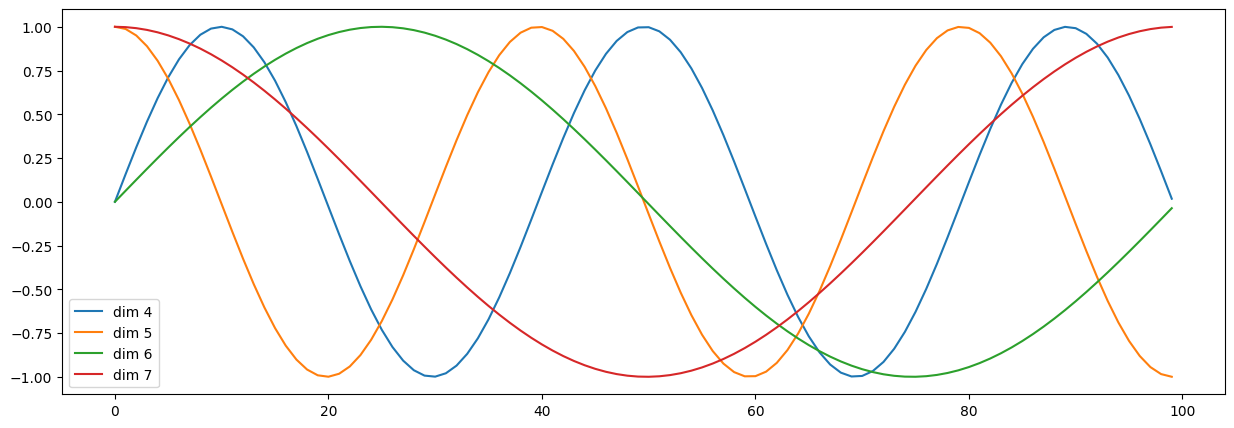

In [19]:
# The positional encoding will add in a sine wave based on position.
# The frequency and offset of the wave is different for each dimension.
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

我们也尝试了使用可学习的位置嵌入（learned positional embeddings）作为替代方案，发现这两种方法产生的结果几乎完全相同。我们最终选择了正弦版本，因为它可能使模型能够外推到比训练期间所见序列更长的长度。

## Generation

In [20]:
class Generator(nn.Module):
    "Standard generation step. (Not described in the paper.)"
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

## 完整模型结构
大多数具有竞争力的神经序列转换模型都采用编码器-解码器结构。在这里，编码器将符号表示的输入序列$(x_1, ..., x_n)$映射到一个连续表示的序列$\mathbf{z} = (z_1, ..., z_n)$。给定$\mathbf{z}$后，解码器随后逐个元素地生成符号的输出序列$(y_1,...,y_m)$。在每一步中，模型都是自回归的，在生成下一个符号时，会将先前生成的符号作为额外输入进行处理。

<img src="./images/transformer_autoencoder.jpg" width=400px>

In [21]:
#整体transformer autoencoder架构
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base model for this and many
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        memory = self.encoder(self.src_embed(src), src_mask)
        output = self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
        return output

In [22]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Construct a model object based on hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model, dropout)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))

    # This was important from their code. Initialize parameters with Glorot or fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

### 模型训练

本节描述了我们模型的训练方案。

#### 训练数据与批处理（Training Data and Batching）

我们在标准的 WMT 2014 英德数据集上进行训练，该数据集包含约 450 万句对。句子采用字节对编码（Byte-Pair Encoding, BPE）进行处理，源语言和目标语言共享一个约 37,000 个词元（token）的词汇表。
对于英法翻译任务，我们使用了规模大得多的 WMT 2014 英法数据集，包含 3,600 万句对，并将词元切分为一个包含 32,000 个词片（word-piece）的词汇表。
在批处理时，我们将长度相近的句子配对组合在一起。每个训练批次包含若干句对，其中源语言端和目标语言端各自大约包含 25,000 个词元。

#### 硬件与训练调度（Hardware and Schedule）

我们在一台配备 8 块 NVIDIA P100 GPU 的机器上训练模型。对于本文所述超参数配置下的基础模型（base models），每个训练步（step）耗时约 0.4 秒。基础模型共训练了 100,000 步，总计约 12 小时。
对于大模型（big models），每步训练耗时约为 1.0 秒，并总共训练了 300,000 步（约 3.5 天）。

#### 优化器（Optimizer）

我们采用了 Adam 优化器，其超参数设置为：$(\beta_1 = 0.9)$、$(\beta_2 = 0.98)$ 以及 $(\epsilon = 10^{-9})$。

在训练过程中，我们根据以下公式动态调整学习率：

$[
\text{lrate} = d_{\text{model}}^{-0.5} \cdot 
\min\left( \text{step\_num}^{-0.5},\ 
\text{step\_num} \cdot \text{warmup\_steps}^{-1.5} \right)
$]

该策略意味着：在前 $( \text{warmup\_steps} )$ 个训练步中，学习率**线性增长**；此后，学习率按训练步数的**负平方根比例衰减**。  
我们设定 $( \text{warmup\_steps} = 4000 )$。 

在前面的warmup_steps的训练步骤里，线性的增加学习率，然后随着步骤的平方根的倒数成正比进行衰减

In [23]:
# Note: This part is incredibly important.
# Need to train with this setup of the model is very unstable.
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup**(-1.5)))

def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

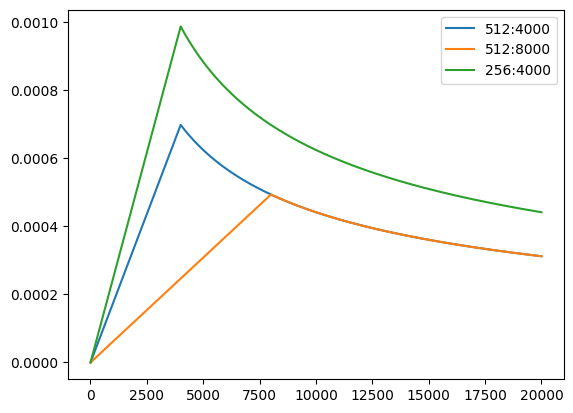

In [24]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None),
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

#### 正则化项：Regularization                                                                                                                                                                              

##### 标签平滑
在训练过程中，我们采用了标签平滑技术，其中平滑值 $\epsilon_{ls}=0.1$。虽然这会使模型学习时变得更加不确定，从而降低困惑度，但却能提高准确率和BLEU分数。  

In [25]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing. 5, 0, 0.5"
    def __init__(self, size, pad_token_id, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        #self.criterion = nn.KLDivLoss(size_average=False)
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.pad_token_id = pad_token_id
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size #vocab_size
        self.true_dist = None

    def forward(self, x, target): #shape of x=[batch_size, vocab_size]，一个字符一个字符计算loss
        assert x.size(1) == self.size
        #先克隆x的data数据（不共享梯度）
        true_dist = x.data.clone()
        #padding和目标标签不参与计算，亦即将真值位置之外的概率分布(smoothing)平摊到其他的token位置
        #将所有位置初始化为smoothing / (vocab_size - 2) 
        true_dist.fill_(self.smoothing / (self.size - 2))
        #将token真值的位置设为confidence，真值定义为soft label
        #真实标签 token（将被设为 confidence）scatter_ 按 target 指定的位置，将对应列设为 confidence,例如：若 target[i] = 3，则 true_dist[i, 3] = confidence
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        #因为 <pad> 是无效 token，不应参与 loss 计算, 即使它被错误地分配了平滑概率，也强制归零
        true_dist[:, self.pad_token_id] = 0
        #对这些样本（行），将整个true_dist行设为0
        mask = torch.nonzero(target.data == self.pad_token_id)
        if mask.dim() > 0:
            # 从0维度进行填充，如果其对应的mask不为0，则这一行所有的分布为0
            # 也就是token为pad的所有vocab_size都不参与loss的计算
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

LabelSmoothing使用示例 LabelSmoothing(5, 0, 0.5)，参数5为vocab_size，即词汇表大小，0为padding的token id，0.5为smoothing因子  
predict为三个token对应的预测输出的概率分布，crit即根据LabelSmoothing进行loss计算

```
torch.LongTensor([2, 1, 0]))-->

tensor([[0.0000, 0.1667, 0.5000, 0.1667, 0.1667],
        [0.0000, 0.5000, 0.1667, 0.1667, 0.1667],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
```

KLDivLoss的内部计算方式是
$[
\text{loss} = -\sum P \cdot \log Q = -\sum P \cdot (\text{log\_Q})
]$

因此计算loss时传入的时predict出概率的log值，可以参考如下的代码示例

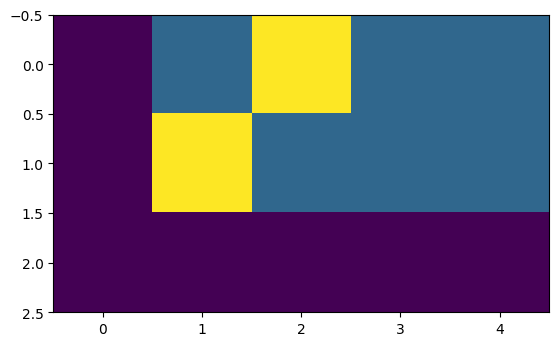

In [26]:
#Example
crit = LabelSmoothing(5, 0, 0.5)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0]])

# KLDivLoss 的第一个参数必须是 log(probabilities)
v = crit(Variable(predict.log()),
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)

随着预测的准确度的增加，loss的下降可视化图示

0.2623642385005951


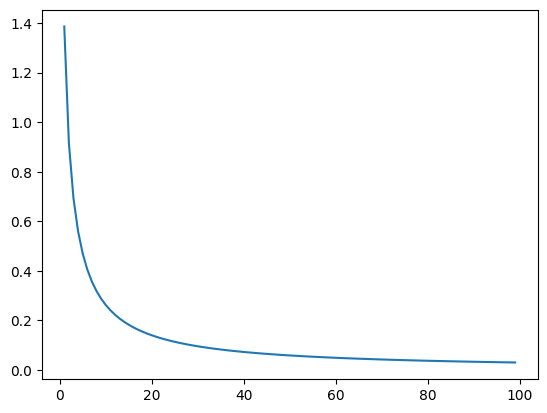

In [27]:
# Label smoothing starts to penalize the model
# if it gets very confident about a given choice
# crit = LabelSmoothing(5, 0, 0.2)
crit = nn.KLDivLoss(reduction='batchmean')
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[1e-9, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    target = torch.FloatTensor([[0, 1, 0, 0, 0]])  # 使用one-hot向量作为目标分布
    return crit(predict.log(), target).item()
    #print(predict)
    # return crit(Variable(predict.log()),
    #              Variable(torch.LongTensor([1]))).item()
print(loss(10.0))
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])

### 计算时空间优化(Memory Optimization)

输出out的张量形状为out->[batch, max_seq_len， d_model]，一般输出的称谓可以是 Logits，Predictions / Token predictions，Output embeddings / Final hidden states ，Scores
Variable(out[:, i].data为第i个token输出的  
用时间换空间：通过一个循环，一次只处理序列中的一个时间步（一个 token），手动计算和累积梯度，从而避免一次性创建和存储那些巨大的中间张量。

补充generator的代码在前面已有描述，这里再应用一下以便阅读

```
class Generator(nn.Module):
    "Standard generation step. (Not described in the paper.)"
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)
```

In [28]:
def loss_backprop(generator, criterion, out, targets, valid_token_counts):
    """
    Memory optmization. Compute each timestep separately and sum grads.
    """
    assert out.size(1) == targets.size(1)
    total_loss = 0.0
    total = 0.0
    out_grad = []
    #print(out.shape)torch.Size([2, 127, 512])
    for i in range(out.size(1)): 
        # out->[batch, max_seq_len， dmodel] for each token
        # 这个循环遍历序列的每一个时间步（token），从 0到 T-1
        # 将这个切片出的数据重新包装成一个新的叶子节点（leaf node）变量 out_column，
        # 并明确告诉 PyTorch 我们需要计算它相对于后续操作的梯度。
        # 这样做是为了构建一个临时的、局部的计算图。
        # Prepare a slice of the output tensor for this time step
        # This slice is detached from the main graph to create a local computation graph.
        out_column = Variable(out[:, i].data, requires_grad=True)
        
        # Generate predictions for this time step
        # Shape: [batch_size, vocab_size]
        gen_out = generator(out_column) 
        
        # Calculate the loss for this time step
        # Note: criterion should be defined with reduction='none' to get per-element loss.
        # e.g., criterion = nn.CrossEntropyLoss(reduction='none', ignore_index=padding_idx)
        loss = criterion(gen_out, targets[:, i]) # Shape: [batch_size]
        
        # 4. Create a mask to filter out padding tokens for this time step
        # A token is valid if its index 'i' is less than the total valid length.
        mask = (i < valid_token_counts).float() # Shape: [batch_size]
        
        # 5. Apply the mask to the loss
        masked_loss = loss * mask # Shape: [batch_size]
        
        # 6. Sum the loss for valid tokens and perform backpropagation
        # We only backpropagate the loss from non-padded tokens.
        # loss.sum() will correctly handle cases where some samples in the batch are masked out.
        loss_sum = masked_loss.sum()
        
        # Accumulate total loss for reporting (normalized by the total number of valid tokens)
        total_loss += loss_sum.item()

        # Perform backpropagation on the local graph to get gradient w.r.t. out_column
        # If loss_sum is 0 (e.g., all samples are padding at this step), no gradient is computed.
        if loss_sum > 0:
            loss_sum.backward()

        # 7. Store the gradient
        # If a sample was masked, its gradient will be zero, which is correct.
        # We need to handle the case where out_column.grad is None if loss_sum was 0.
        grad_data = out_column.grad.data.clone() if out_column.grad is not None else torch.zeros_like(out_column.data)
        out_grad.append(grad_data)            
    out_grad = torch.stack(out_grad, dim=1)
    # 这是连接主计算图并完成整个反向传播过程的魔法。
    # 当在一个张量（非标量）上调用 .backward() 时，你需要提供一个 gradient 参数。
    # 将我们手动计算并拼接好的梯度 out_grad (即 dL/d(out)) 作为起始梯度，从 out 节点开始，沿着主计算图继续向后传播，
    # 从而计算出损失相对于模型中所有更早参数（如 Encoder、Decoder 的权重）的梯度。
    out.backward(gradient=out_grad)
    return total_loss

In [ ]:
# 'input_ids': source['input_ids'].squeeze(),
# 'src_atten_mask': source['attention_mask'].squeeze(),
# 'tgt_atten_mask': target['attention_mask'].squeeze(),
# 'labels': target['input_ids'].squeeze()  # 目标是英语的tokenized形式
# source格式：f"{example['translation']['zh']}",
# target格式：f"{bos_token} {example['translation']['en']} {sep_token}"
def train_epoch(train_iter, model, criterion, opt, transpose=False):
    model.train()
    for i, batch in enumerate(train_iter):
        opt.optimizer.zero_grad()
        # src, trg, src_mask, trg_mask = \
        #     batch.src, batch.trg, batch.src_mask, batch.trg_mask
        #print(batch.keys())
        #[2,1,128]
        #print(batch['input_ids'].shape,batch['labels'].shape, batch['src_atten_mask'].shape, batch['tgt_atten_mask'].shape)
        src, trg, src_mask, trg_mask = \
            batch['input_ids'], batch['labels'], batch['src_atten_mask'], batch['tgt_atten_mask']
        #out = model.forward(src, trg[:, :-1], src_mask, trg_mask[:, :-1])
        out = model.forward(src, trg, src_mask, trg_mask)
        loss = loss_backprop(model.generator, criterion, out[:,:-1,:], trg[:, 1:], batch['valid_token_count'])

        opt.step()

        if i % 10 == 1:
            print(i, loss, opt._rate)

In [30]:
def valid_epoch(valid_iter, model, criterion, transpose=False):
    model.test()
    total = 0
    for batch in valid_iter:
        src, trg, src_mask, trg_mask = \
            batch.src, batch.trg, batch.src_mask, batch.trg_mask
        out = model.forward(src, trg[:, :-1], src_mask, trg_mask[:, :-1, :-1])
        loss = loss_backprop(model.generator, criterion, out, trg[:, 1:], batch.ntokens)


#### 一个实际中的案例

In [31]:
from datasets import load_dataset

# 加载 IWSLT2017 数据集的中文到英语的翻译数据集
dataset = load_dataset('iwslt2017', 'iwslt2017-zh-en',trust_remote_code=True)

# 查看数据集的结构
print(dataset)

# 数据集已经分为训练集、验证集和测试集
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

# 示例：查看训练集中第一条数据
example = train_dataset[0]
print(f"中文: {example['translation']['zh']}")
print(f"英语: {example['translation']['en']}")

d:\programs\miniconda\envs\torch-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using the latest cached version of the module from C:\Users\xulis\.cache\huggingface\modules\datasets_modules\datasets\iwslt2017\03ce9110373117c6f6687719f49f269486a8cd49dcad2527993a316cd4b6ad49 (last modified on Sat Jul  5 13:22:07 2025) since it couldn't be found locally at iwslt2017, or remotely on the Hugging Face Hub.


DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 231266
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 8549
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 879
    })
})
中文: 非常谢谢，克里斯。的确非常荣幸 能有第二次站在这个台上的机会，我真是非常感激。
英语: Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.


In [32]:
from transformers import AutoTokenizer

# 使用预训练的BERT tokenizer
#tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
#BERT基于wordpiece，GPT基于BPE
ch_tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")
en_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


# 获取 [CLS] 和 [PAD] 的 token ID
cls_token_id = en_tokenizer.convert_tokens_to_ids(en_tokenizer.cls_token)
pad_token_id = en_tokenizer.convert_tokens_to_ids(en_tokenizer.pad_token)

print(f"[CLS] Token ID: {cls_token_id}")
print(f"[PAD] Token ID: {pad_token_id}")

# 特殊标记
bos_token = "[CLS]"  # 在BERT中，通常使用[CLS]作为开始标记
sep_token = "[SEP]"  # 在BERT中，通常使用[SEP]作为结束标记

# 定义最大序列长度
max_seq_length = 128
source = ch_tokenizer(
    example['translation']['zh'],
    padding='max_length',
    truncation=True,
    max_length=max_seq_length,
    return_tensors='pt'
)

target = en_tokenizer(
    f"{bos_token} {example['translation']['en']} {sep_token}",
    padding='max_length',
    truncation=True,
    max_length=max_seq_length,
    return_tensors='pt'
)

print(source['input_ids'].squeeze().shape, source['attention_mask'].squeeze().shape)
print(source['attention_mask'].shape, source['attention_mask'])
mask = source['attention_mask'].squeeze()
#[128, 1],[1,128]
att_mask = mask.unsqueeze(-1)@mask.unsqueeze(0)
print(att_mask.shape, att_mask)

d:\programs\miniconda\envs\torch-gpu\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[CLS] Token ID: 101
[PAD] Token ID: 0
torch.Size([128]) torch.Size([128])
torch.Size([1, 128]) tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])
torch.Size([128, 128]) tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


In [33]:
def subsequent_mask_v2(size):
    "Mask out subsequent positions."
    attn_shape = (size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

src_mask基于有效的token进行计算  
tgt_mask基于有效的token和causual masked的交操作进行计算  
如下的代码 make_std_mask 的作用是将一维的 padding mask 转换为二维的注意力掩码（attention mask）  
并为 decoder 添加 causal mask（即防止未来信息泄露的三角掩码）

In [ ]:
# @ 是矩阵乘法运算符，其中subsequent_mask_v2为causal mask，和表示的padding所形成的mark取交集
def make_std_mask(src_mask, tgt_mask, max_seq_len):
    src_mask = src_mask.unsqueeze(-1)@src_mask.unsqueeze(0)
    tgt_mask = tgt_mask.unsqueeze(-1)@tgt_mask.unsqueeze(0)
    tgt_mask = tgt_mask & Variable(subsequent_mask_v2(max_seq_len).type_as(tgt_mask.data))
    return src_mask, tgt_mask

src_mask, tgt_mask = make_std_mask(source['attention_mask'].squeeze(), target['attention_mask'].squeeze(), max_seq_length)
print(src_mask.shape, tgt_mask.shape, target['attention_mask'].sum(dim=1))

torch.Size([128, 128]) torch.Size([128, 128]) tensor([36])


In [40]:
print(source['attention_mask'].shape, source['attention_mask'].squeeze().shape)
print(source['attention_mask'].squeeze().unsqueeze(-1).shape,source['attention_mask'].squeeze().unsqueeze(0).shape)

torch.Size([1, 128]) torch.Size([128])
torch.Size([128, 1]) torch.Size([1, 128])


In [35]:
# 定义编码函数，数据集的预处理
def encode_example(example):
    source = ch_tokenizer(
        example['translation']['zh'],
        padding='max_length',
        truncation=True,
        max_length=max_seq_length,
        return_tensors='pt'
    )
    target = en_tokenizer(
        f"{bos_token} {example['translation']['en']} {sep_token}",
        padding='max_length',
        truncation=True,
        max_length=max_seq_length,
        return_tensors='pt'
    )
    src_mask, tgt_mask = make_std_mask(source['attention_mask'].squeeze(), target['attention_mask'].squeeze(), max_seq_length)
    # 计算有效 token 的数目
    valid_token_count = target['attention_mask'].sum(dim=1)
    return {
        'input_ids': source['input_ids'].squeeze(),
        'src_atten_mask': src_mask,
        'tgt_atten_mask': tgt_mask,
        'valid_token_count':valid_token_count,
        'labels': target['input_ids'].squeeze()  # 目标是英语的tokenized形式
    }

# 对数据集进行tokenization
encoded_train_dataset = train_dataset.map(encode_example)
encoded_validation_dataset = validation_dataset.map(encode_example)
encoded_test_dataset = test_dataset.map(encode_example)

Map: 100%|██████████| 8549/8549 [00:11<00:00, 726.08 examples/s] 


In [36]:
import torch
from torch.utils.data import Dataset, DataLoader

class TranslationDataset(Dataset):
    def __init__(self, encoded_dataset):
        self.dataset = encoded_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.dataset[idx]['input_ids'], dtype=torch.long),
            'src_atten_mask': torch.tensor(self.dataset[idx]['src_atten_mask'], dtype=torch.long),
            'tgt_atten_mask': torch.tensor(self.dataset[idx]['tgt_atten_mask'], dtype=torch.long),
            'labels': torch.tensor(self.dataset[idx]['labels'], dtype=torch.long),
            'valid_token_count': torch.tensor(self.dataset[idx]['valid_token_count'], dtype=torch.long),
        }

# 创建 PyTorch Dataset
train_data = TranslationDataset(encoded_train_dataset)
validation_data = TranslationDataset(encoded_validation_dataset)
test_data = TranslationDataset(encoded_test_dataset)

# 创建 DataLoader
batch_size = 16
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)


In [37]:
#引文有补齐时常用0，其代表padding的含义
print(ch_tokenizer.pad_token_id, en_tokenizer.pad_token_id, ch_tokenizer.vocab_size, en_tokenizer.vocab_size)

0 0 21128 28996


In [38]:
'''
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Construct a model object based on hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model, dropout)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))

    # This was important from their code. Initialize parameters with Glorot or fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model
'''
model = make_model(ch_tokenizer.vocab_size, en_tokenizer.vocab_size, N=6)
model_opt = get_std_opt(model)
#model.cuda()

C:\Users\xulis\AppData\Local\Temp\ipykernel_23272\3246582383.py:17: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  nn.init.xavier_uniform(p)


In [ ]:

criterion = LabelSmoothing(size=en_tokenizer.vocab_size, pad_token_id=en_tokenizer.pad_token_id, smoothing=0.1)
#criterion.cuda()
#其中训练过程输出的代码参考引用,分别为迭代次数，loss，学习率
'''
if i % 10 == 1:
    print(i, loss, opt._rate)
'''
for epoch in range(15):
    train_epoch(train_dataloader, model, criterion, model_opt)
    valid_epoch(validation_dataloader, model, criterion)

1 45610.13069438934 6.987712429686844e-07
11 31883.525182724 4.192627457812107e-06
21 49102.082575798035 7.686483672655528e-06
31 42879.665689468384 1.118033988749895e-05
41 39375.805397987366 1.4674196102342371e-05
51 34067.562084198 1.8168052317185794e-05
61 38747.719551086426 2.1661908532029216e-05
71 32950.522518634796 2.515576474687264e-05
81 46154.6829457283 2.8649620961716057e-05
91 35307.80880880356 3.214347717655948e-05
101 33543.99495124817 3.56373333914029e-05
111 36669.01902914047 3.913118960624633e-05
121 32168.23859977722 4.262504582108975e-05
131 30162.857606887817 4.611890203593317e-05
141 28784.86287879944 4.961275825077659e-05
151 26713.93285369873 5.310661446562001e-05
161 31246.8659157753 5.660047068046343e-05
171 26384.343759536743 6.0094326895306855e-05
181 26858.06179046631 6.358818311015028e-05
191 28379.62651348114 6.70820393249937e-05
201 24069.2883913517 7.057589553983712e-05
211 24955.311567783356 7.406975175468054e-05
221 21285.99528992176 7.756360796952397